In [20]:
%matplotlib notebook 
import numpy as np
from random import random
import networkx
from matplotlib import pyplot as plt
from min_weight_match import mwpm

# Problem 2.1 
# Repetition code with data qubit phenomenological noise [20 points]

Take a distance $d$ repetition code, for which we are only concerned with bit-flip errors. Assume that after preparing a code-state (e.g. $|0\rangle=|0\rangle^{\otimes d}$), every data qubit independently can suffer a bit-flip with the (same) probability $p$. Afterwards, we extract the stabilizer information, which we here model as perfect. Throughout this exercise, restrict to code distances $d = 3,5,7,9$.

**a)** Write a function accepting $d$ and $p$ as input and generating as output an instance of error record and the corresponding syndrome. *Hint: Represent the error record as a numpy array of 0's and 1’s and use e.g. `random.rand()` to generate uniform random numbers.* [3 points]


In [51]:
gen_error_record = lambda p, d: np.array([1 if p > random() else 0 for _ in range(d)])
gen_syndrome = lambda e: np.array([ 1 if (a + b) % 2 else 0 for a, b in zip(e[:-1],e[1:]) ])
gen_record_and_syndrome = lambda p, d: (gen_error_record(p,d), gen_syndrome(gen_error_record(p,d)))

In [52]:
gen_record_and_syndrome(0.3, 7)

(array([1, 0, 0, 1, 0, 1, 0]), array([1, 0, 1, 0, 1, 0]))

**b)** Write a function with the error record as input that returns the correction as a bit-string of the same length. Count the number of bit-flips, if less than half the qubits flipped, undo the errors, otherwise perform the logical complement operation. *This is majority vote decoding*. [3 points]

In [53]:
gen_correction_from_error = lambda e: e if (sum(e) < len(e)/2) else 1 - e

In [62]:
e, _ = gen_record_and_syndrome(0.5, 7)
c = gen_correction_from_error(e)
print(f'     Error: {e}')
print(f'Correction: {c}')

     Error: [0 1 1 1 1 1 1]
Correction: [1 0 0 0 0 0 0]


**c)** Combine the two functions above to decide whether a distance $d$ code with error-rate $p$ resulted in a successful recovery (output 0) or logical error (output 1) for this specific error record realization.[4 points]

In [63]:
check_correction = lambda e, c: all(e == c)

In [69]:
e, _ = gen_record_and_syndrome(0.5, 7)
c = gen_correction_from_error(e)
print(f'{e} == {c} is {check_correction(e, c)}')

[1 0 1 0 1 1 0] == [0 1 0 1 0 0 1] is False


**d)** Take $p\in[0,1]$ with reasonable spacing and odd distances $d= 3,5,7,9$. For each tuple $(p, d)$ sample from the previous function 10,000 times and average over the logical output, i.e. for every tuple $(p, d)$ average over all samples. This is an estimator for the logical error rate. Plot this logical error rate versus physical error rate $p$ for each distance $d$ in one plot with pyplot and determine the value of $p$ below which the performance of the code improves with increasing distance. *Hint: You should set the spacing of $p$, the number of samples and the distance lower first for faster testing/debugging and only increase once you see that your code is producing reasonable results. You should know where to expect the crossing point from the lecture.* [4 points]

1.00, 9


<IPython.core.display.Javascript object>


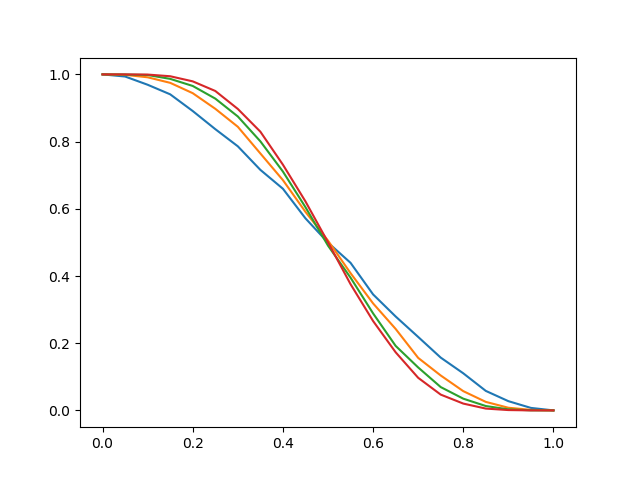

In [70]:
ps = np.linspace(0, 1, 21)
ds = np.array([3, 5, 7, 9])
pd = [[p,d] for p in ps for d in ds]

def gen_single_sample(p, d):
    e, _ = gen_record_and_syndrome(p, d)
    c = gen_correction_from_error(e)
    return check_correction(e, c)

sample_tuple = lambda p, d, N=10000: np.average([gen_single_sample(p, d) for _ in range(N)])

results = []

for p, d in pd:
    print(f'{p:.2f}, {d}', end='\r')
    results.append(sample_tuple(p, d))
print()

R = np.reshape(results, (len(ps), -1))
PD = np.reshape(pd, (len(ps), -1, 2))

plt.figure()
for n, d in enumerate(ds):
    plt.plot(PD[:,n,0], R[:,n])

**e)** Replace the decoding step in b) with minimum weight perfect matching. Instead of using the error record, we now use the syndrome information. Repeat the same sampling as before and produce the corresponding plot and determine the threshold. *Note: for perfect syndrome extraction, this decoder should always output the same thing as majority vote, so this is an easy way to learn MWPM, which generalizes to other error models unlike the previous decoder (see below).*

Guidance: We provided a function that performs minimum weight matching for you, which you can import into your code. The function is extensively documented, read the function description and play around with it to get a grip on how it works, it also provides some sanity checks on the input. It accepts a list of weighted edges, as well as a list of the weights to the boundary for every node. The function internally solves the minimum weight matching problem and returns the result. In order to utilize this function, you have to translate the syndrome defects into the graph problem. Each defect (the location where the syndrome is non-trivial) becomes a node and the weight between two nodes is the number of qubits between the two defects, analogously the weight to the boundary is the number of qubits between the defect at hand and the (closer) boundary. Use this to write a minimum weight matching decoder, i.e. you have to translate your syndrome to use the `mwpm` function and then you have to write a function that interprets the result, i.e. translates the matching into a correction string that should be applied to the qubits. Perform the logical error rate study analogous to question b), again generating a plot from which you estimate the threshold. 

*Hint: For any error, the error string + correction string must always be a logical trivial operator or a logical X operation, this is a good consistency check to start with. Again start with small samples and dial up the sample size when you are confident that you see the right behavior.* [6 points]

In [28]:
def bulk_edges(s):
    V = []
    for i, _ in enumerate(s):
        if s[i]:
            for j, _ in enumerate(s[i+1:]):
                if s[i+j+1] == 1:
                    V.append((i, i+j+1, j+1))
                    
    return V

def boundary_edges(s):
    V = []
    for i, v in enumerate(s):
        if v:
            V.append((i, min(i+1,len(s) - (i))))
    return V

def gen_correction_from_syndrome(s):
    bulk_edges_weighted = bulk_edges(s)
    boundary_edges_weighted = boundary_edges(s)
    
    bulk_matches, boundary_matches = mwpm(bulk_edges_weighted, boundary_edges_weighted)
    
    c = [0] * (len(s) + 1)
    for bm in bulk_matches:
        for i in range(bm[0]+1, bm[1]+1):
            c[i] = 1
    
    for bm in boundary_matches:
        closest_boundary = 0 if bm < (len(s) + 1)/2 else len(s) + 1
        start = min(bm+1, closest_boundary)
        end = max(bm+1, closest_boundary)
        for i in range(start, end):
            c[i] = 1
    
    return np.array(c)

In [29]:
e, s = gen_record_and_syndrome(0.5, 7)
print('e =', e)
print('s =', s)
#print(bulk_edges(s))
#print(boundary_edges(s))
c = gen_correction_from_syndrome(s)
print('c = ', c)
check_correction(e, c)

e = [1 1 0 1 0 0 1]
s = [0 1 1 1 0 1]
c =  [0 0 1 0 1 1 0]


False

1.00, 9


<IPython.core.display.Javascript object>


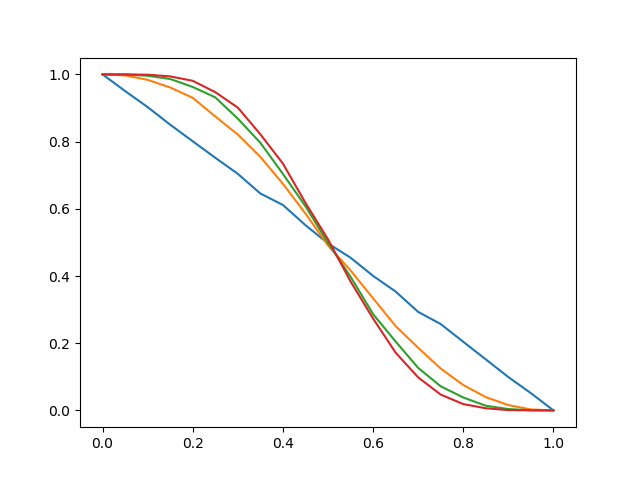

In [32]:
ps = np.linspace(0, 1, 21)
ds = np.array([3, 5, 7, 9])
pd = [[p,d] for p in ps for d in ds]

def gen_single_sample(p, d):
    e, s = gen_record_and_syndrome(p, d)
    c = gen_correction_from_syndrome(s)
    return check_correction(e, c)

sample_tuple = lambda p, d, N=10000: np.average([gen_single_sample(p, d) for _ in range(N)])

results = []

for p, d in pd:
    print(f'{p:.2f}, {d}', end='\r')
    results.append(sample_tuple(p, d))
print()

R = np.reshape(results, (len(ps), -1))
PD = np.reshape(pd, (len(ps), -1, 2))

plt.figure()
for n, d in enumerate(ds):
    plt.plot(PD[:,n,0], R[:,n])

# Problem 2.2
# Repetition code with data and ancilla qubit phenomenological noise[26 points]

Now include a form of ancilla qubit noise, i.e. ancilla qubits can flip with some probability. As discussed in the lecture, in this case we always repeat a distance-$d$ code $d$ times, where we use fresh ancillas every round. Model the ancilla noise as happening with the same probability $p$ as the data qubit noise once per round, preceding the ancilla readout. Furthermore assume perfect initialization preceding the first round and perfect final readout, i.e. prepare a codestate, then switch on data qubit noise with probability $p$ each subsequent round, on which you do $d−1$ rounds of noisy syndrome extraction and one final round of perfect syndrome extraction.

**a)** Generate a record of data and ancilla qubit errors and the corresponding syndrome volume. You can first generate the error record, you would get with pure data qubit noise, then extract its syndrome (note that data qubit errors persist in time until they are canceled out by another error on the same qubit) and then add noise to the syndrome according to the above description. Choose a two-dimensional numpy array and use the first dimension as the time coordinate (time-step index) and the second as the spatial coordinate (ancilla qubit index). [4 points]

In [74]:
d = 7
p = 0.1
data_state = [0] * d

apply_error = lambda qubits, p: np.array([ (q + 1) % 2 if p > random() else q for q in qubits])

data_state = apply_error(data_state, 0.1)
print(data_state)

record = []

ancilla_state = gen_syndrome(data_state)
print(ancilla_state)
for m in range(d - 1):
    ancilla_state = gen_syndrome(data_state)
    ancilla_state = apply_error(ancilla_state, 0.1)

ancilla_state = gen_syndrome(data_state)

[0 0 0 1 0 0 1]
[0 0 1 1 0 1]


**b)** As discussed in the lecture, we now care about where the syndrome changes between subsequent rounds. As part of your function, take the discrete derivative in time of the syndrome volume (modulo 2). This gives you a two-dimensional array where an entry value 1 indicates the position of a defect you will later feed into the decoder. To keep track of the coordinates, record the time and space coordinates of all defects in a separate array. [4 point]

**c)** From your list of defects, we need to perform the MWPM on the syndrome graph analogous to exercise 1. You can still use the same function we provided for minimum weight matching, but you have to adapt the weights to the now two-dimensional setting. Write a function that implements this and calls the `mwpm` routine. [6 points]

**d)** Write a function (or add to the previous above function), that interprets the result of the matching and returns the correction string we should apply after the final time step. For this you have to think about the spatial and the temporal contribution of error strings to the final correction, which we want to apply in the end to get back to the (hopefully correct) codestate. It is again true, that the error record projected onto the final timeslice plus the potential correction string can only be either a logical trivial operator or a logical X operator, which is also here a good consistency check for your decoder. [6 points]

**e)** Again as above, now vary $p$ and the distance and sample for every parameter tuple, eventually dialing up to 10,000 samples after you gained confidence that your methods are behaving as expected. You can focus on the interval $p\in(0.05,0.15)$ where you should see the decisive behavior. Plot physical vs. logical error rate for varying distance and find the approximate value of the threshold error rate $p_{th}$. [6 points]